# Response_4: Latent Structure Analysis

### Table of Contents
- [1. Load Data](#1-load-data)  

- [2. Help function](#2-help-function)  

- [3. Preprocessing data](#3-preprocessing-data)

- [4. Word embedding](#3-word-embedding)

- [5. Latent structure transforming](#3-latent-structure-transforming)

- [6. Classification on the transformed latent structure](#3-classification-on-the-transformed-latent-structure)




In [33]:
import pandas as pd
import numpy as np

import spacy
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [64]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score

### 1. Load data

In [5]:
df = pd.read_csv('datasets/feature_extraction.csv')
df = df.iloc[:,1:]

In [6]:
df = df[['response_corrected', 'score']]

In [7]:
df.head()

,response_corrected,score
0,"During my journey, I faced a big health proble...",3
1,I once had a big problem when I wasn't ready f...,3
2,During my junior year I faced a significant ch...,3
3,"Once, I encountered a situation that was quite...",2
4,"During a trip, I suffered a serious accident t...",3


In [14]:
documents = df['response_corrected']

### 2. Help function

In [17]:
def print_formatted_paragraph(text, words_per_line=20):
    """
    Prints the given text in a formatted manner, breaking it into lines with a specified number of words per line.

    Parameters:
    - text (str): The text to be formatted and printed.
    - words_per_line (int): The maximum number of words to display per line. Default is 20.
    """
    words = text.split()
    formatted_paragraph = "\n".join(" ".join(words[i:i + words_per_line]) for i in range(0, len(words), words_per_line))
    print(formatted_paragraph)

In [41]:
def plot_each_topic(model, num_topic, num_keyword, index_list, save_path=None):
    each_topic_df = pd.DataFrame(model.components_)
    specific_df = each_topic_df.iloc[num_topic,:]
    specific_df.index = index_list
    plot_series = specific_df.sort_values(ascending=False).head(num_keyword)
    plot_dict = plot_series.to_dict()

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')

    wordcloud = wordcloud.generate_from_frequencies(plot_dict)
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot if save_path is provided
        print(f"Wordcloud saved to {save_path}")
    else:
        plt.show()

In [63]:
def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """
    Compute the Quadratic Weighted Kappa (QWK) score, a measure of agreement between two ordinal ratings. QWK accounts for the severity of disagreements using a quadratic weight matrix.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples,)
        Ground truth ratings.
    y_pred : array-like of shape (n_samples,)
        Predicted ratings.
    min_rating : int, optional (default=1)
        Minimum possible rating.
    max_rating : int, optional (default=5)
        Maximum possible rating.

    Returns:
    --------
    float
        Quadratic Weighted Kappa score (1 indicates perfect agreement, 
        0 indicates random agreement, and negative values indicate worse-than-random agreement).
    """

    # Define rating range
    ratings = np.arange(min_rating, max_rating + 1)
    num_ratings = len(ratings)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=ratings).astype(np.float64)
    
    # Normalize confusion matrix to probability distribution
    cm /= cm.sum()

    # Compute expected matrix under independence assumption
    row_marginals = cm.sum(axis=1, keepdims=True)
    col_marginals = cm.sum(axis=0, keepdims=True)
    expected_matrix = row_marginals @ col_marginals  # Outer product
    expected_matrix /= expected_matrix.sum()

    # Construct quadratic weight matrix
    weight_matrix = np.square(np.subtract.outer(ratings, ratings)) / (num_ratings - 1) ** 2

    # Compute QWK score
    numerator = np.sum(weight_matrix * cm)
    denominator = np.sum(weight_matrix * expected_matrix)

    return 1 - (numerator / denominator)

In [65]:
from sklearn.metrics import make_scorer

qwk_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

### 3. Preprocess data

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
token_map = {}
custom_stop_words = set([])

non_lemma_dict = {}

In [12]:
all_stop_words = nlp.Defaults.stop_words.union(custom_stop_words)

In [13]:
def preprocess_text(text):
    # Process the text using spaCy
    text = text.lower()
    doc = nlp(text)
    
    # Initialize lists to store tokens and noun chunks
    tokens = []

    # Process tokens
    for token in doc:
        # Check if the token should be included
        if (not token.is_punct and
            not token.is_space and
            not token.is_digit and
            token.is_alpha and
            token.lemma_ not in all_stop_words):
            
            lemma = token.lemma_
            if lemma in non_lemma_dict.keys():
                lemma = non_lemma_dict[lemma]
            if lemma in token_map.keys():
                lemma = token_map[lemma]

            tokens.append(lemma)
    
    new_text = ' '.join(tokens)
    return new_text

In [15]:
processed_docs = [preprocess_text(doc) for doc in documents]

In [18]:
print_formatted_paragraph(processed_docs[0], words_per_line=20)

journey I face big health problem test strength ability find solution I tough time I find strong way adjust hard
situation help I feel determined lead future success I learn care help help I grow person I good thing like
build strong friendship school journey I important I feel confident strong come


### 4. Word embedding

**TF-IDF (Term Frequency-Inverse Document Frequency)**
- Description: Extends BoW by weighting words based on importance (frequency in a document vs. across all documents).
- Limitations: Still ignores word order and relationships between words.

In [19]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    max_features=2000,
)

In [20]:
tfidf_doc = tfidf.fit_transform(processed_docs)

In [21]:
word_list = list(tfidf.get_feature_names_out())
tfidf_result = pd.DataFrame(tfidf_doc.toarray(), columns=word_list)

In [23]:
tfidf_result.head()

,ability,ability adapt,ability navigate,ability thrive,able,academic,academic challenge,academic endeavor,academic journey,academic performance,...,year,year big,year college,year encounter,year face,year high,year hit,year try,youth,zone
0,0.102982,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.129456,0.0,0.0,0.0,0.0,0.0,...,0.074828,0.0,0.0,0.0,0.11718,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [24]:
tfidf_result.to_csv('datasets/tf-idf_result.csv')

### 5. Latent Structure Transforming

In [25]:
# Here, we are using NMF to do this latent structure analysis

In [48]:
nmf = NMF(n_components=15, random_state=42, max_iter=400)

In [49]:
nmf.fit(tfidf_doc)

NMF(max_iter=400, n_components=15, random_state=42)

In [50]:
nmf_topic_combination = pd.DataFrame(nmf.components_, columns = tfidf_result.columns)
nmf_topic_combination

,ability,ability adapt,ability navigate,ability thrive,able,academic,academic challenge,academic endeavor,academic journey,academic performance,...,year,year big,year college,year encounter,year face,year high,year hit,year try,youth,zone
0,0.010621,0.000000,0.024932,0.000000,0.000000,0.091439,0.046334,0.000000,0.000000,0.041619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.028656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025736,0.000000,0.000000
2,0.000000,0.001073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.126239,0.000000,0.000000,0.000000,0.000000,0.000000,0.001034,0.033879,0.128063,0.000000
3,0.022628,0.000000,0.000000,0.000000,0.000000,0.000000,0.007288,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001648,0.000000,0.000000,0.000000,0.000000,0.000027
4,0.021214,0.021858,0.000000,0.000000,0.010705,0.488494,0.165717,0.033975,0.058847,0.028606,...,0.253996,0.000000,0.102151,0.093333,0.056514,0.017838,0.016151,0.001408,0.000000,0.016837
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027128,0.000000,0.006755,0.000000,0.000000,0.000000,0.051783,0.008697,0.000000,0.000000
6,0.011314,0.000000,0.005437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001215,...,0.060599,0.007200,0.011034,0.013771,0.001712,0.001396,0.000000,0.000000,0.000000,0.002081
7,0.039863,0.000000,0.000000,0.006063,0.040956,0.033602,0.000000,0.000000,0.000000,0.076905,...,0.075338,0.001911,0.004409,0.001192,0.100540,0.020890,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.004243,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.046641,0.000000,0.000000,0.000000,0.044345,0.000000,0.000000,0.002010,0.000000,0.009497
9,0.068092,0.020109,0.016877,0.000000,0.012951,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042163,0.000000,0.000000,0.004128,0.007138,0.000000,0.004437,0.000000,0.000742,0.072267


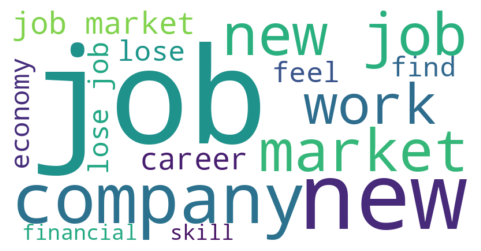

In [ ]:
plot_each_topic(nmf, 8, 15, word_list, save_path=None)

Wordcloud saved to datasets/topic_modeling/topic_0
Wordcloud saved to datasets/topic_modeling/topic_1
Wordcloud saved to datasets/topic_modeling/topic_2
Wordcloud saved to datasets/topic_modeling/topic_3
Wordcloud saved to datasets/topic_modeling/topic_4
Wordcloud saved to datasets/topic_modeling/topic_5
Wordcloud saved to datasets/topic_modeling/topic_6
Wordcloud saved to datasets/topic_modeling/topic_7
Wordcloud saved to datasets/topic_modeling/topic_8
Wordcloud saved to datasets/topic_modeling/topic_9
Wordcloud saved to datasets/topic_modeling/topic_10
Wordcloud saved to datasets/topic_modeling/topic_11
Wordcloud saved to datasets/topic_modeling/topic_12
Wordcloud saved to datasets/topic_modeling/topic_13
Wordcloud saved to datasets/topic_modeling/topic_14


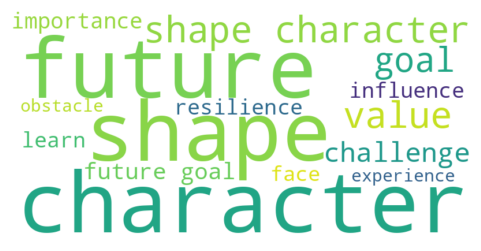

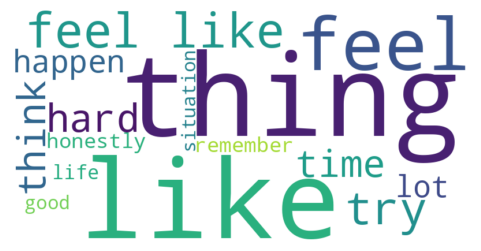

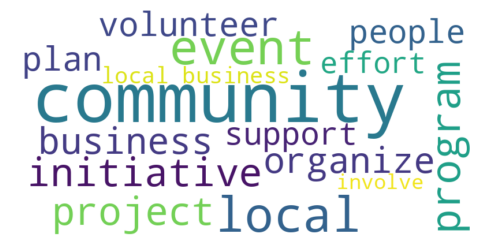

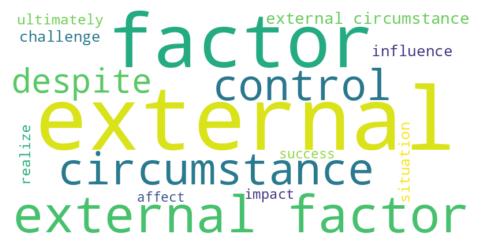

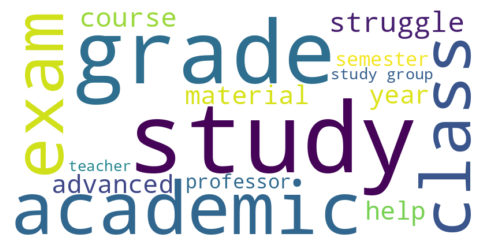

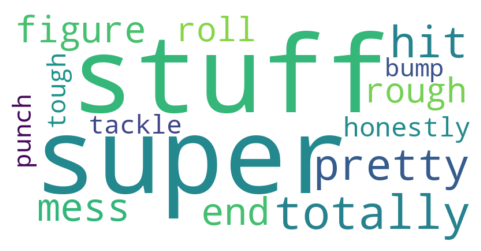

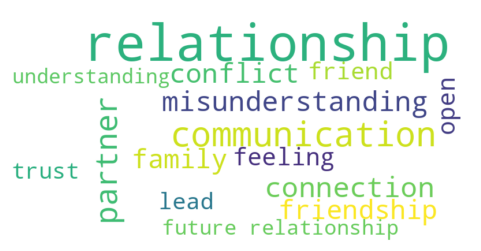

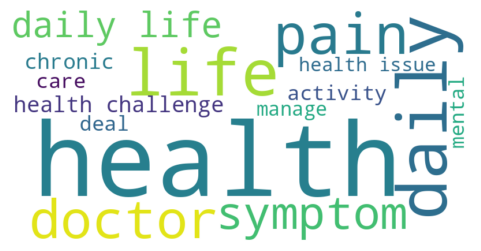

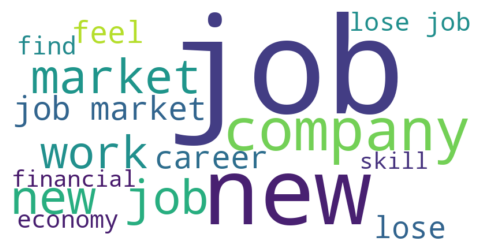

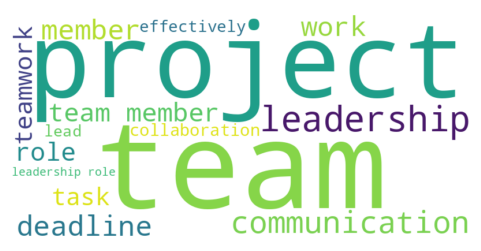

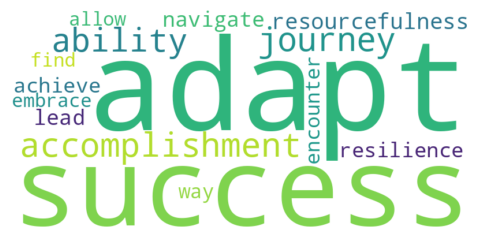

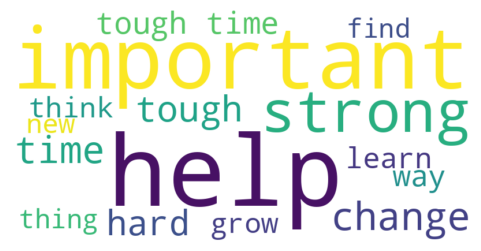

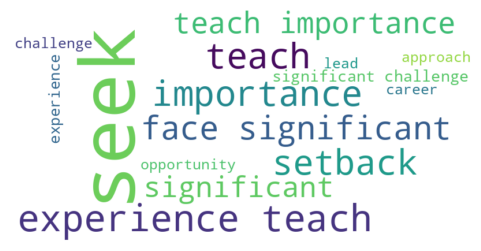

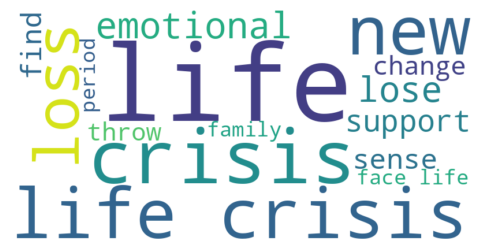

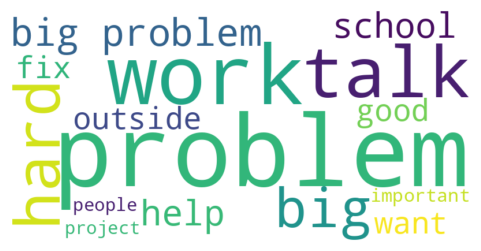

In [54]:
for i in range(15):
    save_path = f'datasets/topic_modeling/topic_{i}'
    plot_each_topic(nmf, i, 15, word_list, save_path=save_path)

In [55]:
nmf_result = nmf.transform(tfidf_doc)

In [57]:
column_list = ['topic_'+str(i) for i in range(1,16)]
nmf_resutl_df = pd.DataFrame(nmf_result, columns = column_list)

In [58]:
nmf_resutl_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,0.000000,0.008649,0.000000,0.000000,0.000000,0.000000,0.003750,0.043746,0.000000,0.000000,0.054473,0.196533,0.000000,0.000000,0.053812
1,0.003473,0.064256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046779,0.000000,0.000000,0.174154
2,0.000000,0.000000,0.000138,0.001037,0.012350,0.000000,0.000973,0.035216,0.012222,0.000000,0.000000,0.018857,0.131593,0.008546,0.014275
3,0.000000,0.000000,0.000000,0.095814,0.058194,0.000000,0.002597,0.000000,0.000000,0.000000,0.063502,0.000000,0.002749,0.000000,0.000000
4,0.000000,0.000000,0.006475,0.013764,0.000000,0.010693,0.000000,0.033112,0.001753,0.003992,0.011381,0.004470,0.051984,0.006659,0.000000


In [59]:
nmf_resutl_df.shape

(1000, 15)

### 6. Classification on the transformed latent structure

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [61]:
X = nmf_resutl_df
y = df['score']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)

In [81]:
lr = LogisticRegression(
    multi_class = 'multinomial', 
    solver = 'lbfgs',
    penalty = 'l2',
    max_iter = 5000,
    random_state=21
    )

param_grid = {
    'C':[0.1, 1, 10, 100, 1000],

}

sss = StratifiedShuffleSplit(n_splits=5, random_state=21)

search_lr = GridSearchCV(
    lr,
    param_grid=param_grid,
    cv=sss,
    verbose=1,
    scoring = qwk_scorer
)

search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=21, test_size=None,
            train_size=None),
             estimator=LogisticRegression(max_iter=5000,
                                          multi_class='multinomial',
                                          random_state=21),
             param_grid={'C': [0.1, 1, 10, 100, 1000]},
             scoring=make_scorer(quadratic_weighted_kappa), verbose=1)

In [82]:
search_lr.best_params_

{'C': 100}

In [83]:
y_test_prediction = search_lr.best_estimator_.predict(X_test)

In [84]:
y_test_prediction

array([3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 5, 4, 5, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 3, 4, 4, 5, 3, 3, 3, 3, 4, 3,
       5, 3, 2, 3, 3, 3, 2, 5, 4, 5, 4, 5, 5, 3, 4, 4, 3, 3, 3, 3, 2, 4,
       3, 3, 5, 2, 5, 5, 5, 2, 3, 3, 3, 3, 5, 3, 3, 4, 5, 3, 3, 4, 4, 4,
       4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 2, 3, 3, 3, 2, 5, 2, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 5, 3, 4, 2, 3, 3, 4, 3, 3, 4, 3, 2, 4, 3, 4,
       3, 3, 2, 2, 3, 3, 3, 5, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3,
       2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 2, 3, 3, 3, 5,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 5, 5, 2, 4, 5,
       4, 3])

In [85]:
y_test

150    2
880    4
416    4
35     2
925    4
      ..
482    1
194    4
502    5
551    4
276    3
Name: score, Length: 200, dtype: int64

In [86]:
accuracy_score(y_test, y_test_prediction)

0.49

In [87]:
quadratic_weighted_kappa(y_test, y_test_prediction, min_rating=1, max_rating=5)

0.5923431407302375

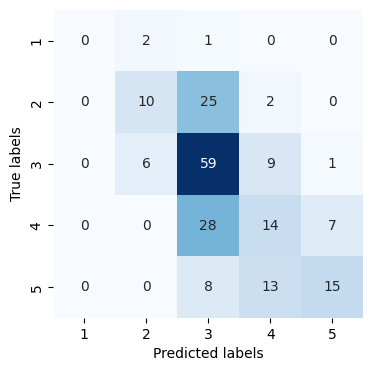

In [88]:
conf_matrix = confusion_matrix(y_test, y_test_prediction, labels=None, sample_weight=None, normalize=None)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6), cbar=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [90]:
coef_df = pd.DataFrame(search_lr.best_estimator_.coef_, columns = X.columns)
coefficients = search_lr.best_estimator_.coef_
abs_coefficients = np.abs(coefficients)
feature_importance = np.mean(abs_coefficients, axis=0)

coef_df = pd.DataFrame(feature_importance, index = X.columns).reset_index()
coef_df.columns = ['feature', 'significance']

In [91]:
alt.Chart(coef_df).mark_bar().encode(
    x=alt.X('feature',sort='-y', title=''),
    y='significance',
    color=alt.Color('significance:Q', 
        scale=alt.Scale(scheme='blueorange'),  # Cold-Warm color mapping
        legend=None
    )
).properties(
    width=500, height=200
)

alt.Chart(...)